In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import numpy as np
import numpy.linalg as la

def add_relative_to_current_source_file_path_to_sys_path(relpath):
    import os, sys, inspect
    path = os.path.realpath(os.path.abspath(os.path.join(os.path.split(inspect.getfile(inspect.currentframe()))[0],relpath)))
    if path not in sys.path:
        sys.path.insert(0,path)

add_relative_to_current_source_file_path_to_sys_path("../../shims/toric")   

import toric
import toric.samples
import toric.shims

def slerp(p0, p1, t):
        omega = np.arccos(np.dot(p0/np.linalg.norm(p0), p1/np.linalg.norm(p1)))
        so = np.sin(omega)
        return np.sin((1.0-t)*omega) / so * p0 + np.sin(t*omega)/so * p1

def drawSetup(fudgeX=2, fudgeY_pos=2,fudgeY_neg=8):
    pylab.rcParams['figure.figsize'] = 8, 8

    plt.axes().set_aspect('equal')
    fig = plt.gcf()
    
    # Set up plot size
    plt.axes().set_xlim((np.min([PA_1.x(), PB_1.x()])-fudgeX,np.max([PA_1.x(), PB_1.x()])+fudgeX))
    plt.axes().set_ylim((np.min([PA_1.y(), PB_1.y()])-fudgeY_neg,np.max([PA_1.y(), PB_1.y()])+fudgeY_pos))

    # Draw People Positions
    plt.scatter([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()],c="red",linewidths=0)
    line_AB = plt.Line2D([PA_1.x(), PB_1.x()],[PA_1.y(), PB_1.y()], c="black",alpha=0.3)
    fig.gca().add_artist(line_AB)

    # Draw Circles    
    circle_PA_1=plt.Circle((PA_1.x(),PA_1.y()),min_dist,color='g',alpha=0.5)
    circle_PB_1=plt.Circle((PB_1.x(),PB_1.y()),min_dist,color='g',alpha=0.5)
    
    fig.gca().add_artist(circle_PA_1)
    fig.gca().add_artist(circle_PB_1)

    plt.annotate(s="A", xy=(PA_1.x(),PA_1.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="B", xy=(PB_1.x(),PB_1.y()),xytext=(3,4),textcoords="offset points")
    
    # Draw Camera positions
    plt.scatter([C_0.x(), C_1.x()],[C_0.y(), C_1.y()],c="blue",linewidths=0)
    plt.annotate(s="C0", xy=(C_0.x(), C_0.y()),xytext=(3,4),textcoords="offset points")
    plt.annotate(s="C1", xy=(C_1.x(), C_1.y()),xytext=(3,4),textcoords="offset points")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# An alternative to averaging trajectories: The magic $w_i(\vec{\sigma}_A,\vec{\sigma}_B,u)$ function

Recall from the notebook *"NJ - 06 - Toric Interpolation Proof of Min Dist Constraint Maintenance"*

We are attempting to find $\vec{\sigma}(u)$ that respects the following constraints:


$$
\begin{align}
\|\vec{\sigma}(u) - \vec{A}\| && \geq && d_m \\
\|\vec{\sigma}(u) - \vec{B}\| && \geq && d_m
\end{align}
$$

<span style="color: green"> 
**NOTE TO SELF:** If you start easing the change in screen position, you can either ease your movement along this trajectory... Or you can find a *different* trajectory that has the same visual easing behavior but with a potentially shorter camera path. To do this we need a joint optimization approach.
</span>

We also have these nice *spherical interpolation* functions. Moving along this trajectory will linearly change the size of people on screen.

$$
\begin{align}
\vec{\sigma}_A(u) & = \vec{A} + d_A(u)\vec{v}_A(u) \\
\vec{\sigma}_B(u) & = \vec{B} + d_B(u)\vec{v}_B(u) \\
\end{align}
$$


Notice that $\vec{\sigma}_A(u)$ respects the minimum distance bounds on A, and $\vec{\sigma}_B(u)$ respects the minimum distance bounds on B. Thus, we are only concerned with $\vec{\sigma}_A(u)$ coming close to B and vice versa.

Let's suggest a different way to combine these two trajectories. Intuitively:

* We want a function that, if both $\vec{\sigma}_A(u)$ and $\vec{\sigma}_B(u)$ are far away from A and B, just averages the two. If $\vec{\sigma}_A(u)$ gets close to B, it picks only $\vec{\sigma}_B(u)$, and vice versa.
* This function needs to guarantee C4-or-better continuity to generate quadrotor feasible paths.
* We want to algebraically formulate this function so its easy to evaluate, ideally.

Let's formulate this function and its behavior explicitly. We call it $w_i(\vec{\sigma}_A,\vec{\sigma}_B;u)$

$$
w_A(\vec{\sigma}_A,\vec{\sigma}_B;u)= 
\begin{cases}
    1,& \text{if }  \|\vec{\sigma}_B(u) - A\| \leq d_{min}\\
    0,& \text{if }  \|\vec{\sigma}_A(u) - B\| \leq d_{min}\\
    0.5,              & \text{otherwise}
\end{cases}
$$

Which we generalize to

$$
w_i(\vec{\sigma}_i,\vec{\sigma}_{j};u)= 
\begin{cases}
    1,& \text{if }  \|\vec{\sigma}_j(u) - i\| \leq d_{min}\\
    0,& \text{if }  \|\vec{\sigma}_i(u) - j\| \leq d_{min}\\
    0.5,              & \text{otherwise}
\end{cases}
$$


Here's how we calculate the full trajectory $\vec{\sigma}(u)$:

$$
\vec{\sigma}(u) = w_A(\vec{\sigma}_A,\vec{\sigma}_B,u)\cdot\vec{\sigma}_A(u) \;\, + \;\, w_B(\vec{\sigma}_B,\vec{\sigma}_A,u)\cdot\vec{\sigma}_A(u)
$$

** Restriction: We still consider the case where $\vec{C}_0$ and $\vec{C}_1$ are both on the same side of the line $AB$.** We might be able to relax this restriction, but lets keep it in place for the moment

## Let's implement that if-statement directly. Notice it violates C4, but thats okay.

Notice that, if we do that directly, we won't have ANY continuity, not even in position. Let's confirm.


In [34]:
min_dist = 1                    # let's set a minimum distance of 1m
PA_1 = toric.Vector3(0,0,0)     # person A position
PB_1 = toric.Vector3(6,0,0)     # person B position
C_0 = toric.Vector3(-1.1,-0.2,0)  # Starting camera position is *outside* of PA_1
C_1 = toric.Vector3( 2.1,-0.2,0)    # Ending camera position

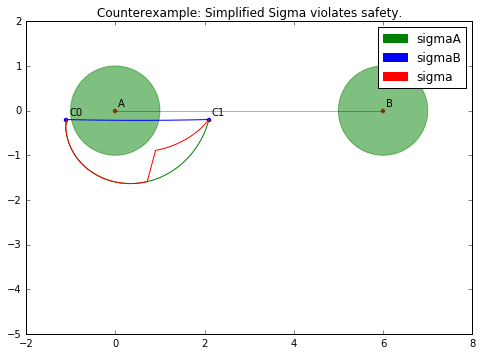

In [35]:
# Create Numpy arrays
A = PA_1.np()
B = PB_1.np()
C0 = C_0.np()
C1 = C_1.np()

# Set up interpolation vector
u = np.c_[np.linspace(0,1)]

# Set up the distance components of sigmaA, sigmaB
dA0 = la.norm(C0 - A)
dA1 = la.norm(C1 - A)
dB0 = la.norm(C0 - B)
dB1 = la.norm(C1 - B)

dA = np.linspace(dA0, dA1)
dB = np.linspace(dB0, dB1)

# Set up the vantage vector components of sigmaA, sigmaB
vA0 = (C0 - A) / dA0
vA1 = (C1 - A) / dA1
vB0 = (C0 - B) / dB0
vB1 = (C1 - B) / dB1

vA = np.apply_along_axis(lambda u : slerp(vA0,vA1,u), axis=1, arr=u)
vB = np.apply_along_axis(lambda u : slerp(vB0,vB1,u), axis=1, arr=u)

# Set up sigmaA, sigmaB, sigma
sigmaA = A + dA[:,np.newaxis] * vA
sigmaB = B + dB[:,np.newaxis] * vB


def calc_weight(sigma_i, sigma_j, i, j):
    def silly_map(sigmas):
        sigmaiu = sigmas[0:3]
        sigmaju = sigmas[3:6]
        if la.norm(sigmaju - i) < min_dist:
            return 1
        elif la.norm(sigmaiu - j) < min_dist:
            return 0
        else:
            return 0.5
    
    return np.apply_along_axis(silly_map, axis=1, arr=np.c_[sigma_i, sigma_j]) 

wA = calc_weight(sigmaA, sigmaB, A, B)
wB = calc_weight(sigmaB, sigmaA, B, A)

sigma = (wA[:,np.newaxis]*sigmaA + wB[:,np.newaxis]*sigmaB)


drawSetup(fudgeY_neg=5)
plt.plot(sigmaA[:,0],sigmaA[:,1], c="green")
plt.plot(sigmaB[:,0],sigmaB[:,1], c="blue")
plt.plot(sigma[:,0], sigma[:,1],  c="red")
plt.title("Counterexample: Simplified Sigma violates safety.")

sA_legend = mpatches.Patch(color="green", label="sigmaA")
sB_legend = mpatches.Patch(color="blue", label="sigmaB")
S_legend  = mpatches.Patch(color="red", label="sigma")
plt.legend(handles=[sA_legend,sB_legend,S_legend])